# Code for making predictions with and without news features

## Libraries/Data required

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Helper functions
from helper_functions import create_lag_df
from helper_functions import plot_ConfusionMatrix

data_dir = "data/" # Define data path

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

In [3]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
df['district'] = df['district'].str.replace("Center", "").str.replace("South", "").str.replace("North", "").str.replace("East", "").str.replace("West", "").str.strip()
df.set_index(["date", "district"], inplace=True) # Set index
numeric_columns = df.select_dtypes(include=['number'])
df = df.groupby(["date", "district"])[numeric_columns.columns].mean().reset_index()
df.set_index(["date", "district"], inplace=True) # Set index
df = df.round({'ipc': 0})
df

district_code      centx     centy    year  month  ipc  \
date       district                                                            
2007-01-01 Abiemnhom          136.0  29.130190  9.550939  2007.0    1.0  NaN   
           Akobo              114.0  32.853080  7.799214  2007.0    1.0  NaN   
           Anzara              86.0  28.205980  5.309739  2007.0    1.0  NaN   
           Aweil              120.6  27.139798  8.918846  2007.0    1.0  NaN   
           Awerial             99.0  31.229460  6.150162  2007.0    1.0  NaN   
...                             ...        ...       ...     ...    ...  ...   
2020-02-01 Wau                103.0  27.298230  7.284772  2020.0    2.0  3.0   
           Wulu               105.0  29.208890  6.200243  2020.0    2.0  2.0   
           Yambio              82.0  28.547290  5.124909  2020.0    2.0  3.0   
           Yei                 81.0  30.344540  4.252148  2020.0    2.0  3.0   
           Yirol              104.0  30.644715  6.594219  2020.0    2.0  4.0   

                       ha  ndvi_mean  ndvi_anom  rain_mean  ...   et_mean  \
date       district                                         ...             
2007-01-01 Abiemnhom  NaN   0.316412  100.55130   0.025810  ...  0.597288   
           Akobo      NaN   0.361317  114.89340   0.205147  ...  1.113290   
           Anzara     NaN   0.414913   94.84704   0.597445  ...  1.454028   
           Aweil      NaN   0.316901  101.51741   0.026128  ...  1.247115   
           Awerial    NaN   0.389172  106.39390   0.255114  ...  0.510219   
...                   ...        ...        ...        ...  ...       ...   
2020-02-01 Wau        0.0   0.370605  101.23200   0.597954  ...  0.122069   
           Wulu       0.0   0.374735  108.55950   0.665396  ...  0.125452   
           Yambio     0.0   0.468085  103.87600   1.465522  ...  2.018053   
           Yei        0.0   0.452878  105.17720   2.409410  ...  7.450696   
           Yirol      0.0   0.364909  118.40925   0.531674  ...  0.370820   

                       et_anom  count_violence  sum_fatalities  \
date       district                                              
2007-01-01 Abiemnhom  0.162672             0.0             0.0   
           Akobo      0.265087             0.0             0.0   
           Anzara    -1.051144             0.0             0.0   
           Aweil      0.455079             0.0             0.0   
           Awerial   -0.027814             0.0             0.0   
...                        ...             ...             ...   
2020-02-01 Wau       -0.105357             0.0             0.0   
           Wulu      -0.243994             1.0             1.0   
           Yambio     0.066441             0.0             0.0   
           Yei        4.531602             0.0             0.0   
           Yirol     -0.021709             1.5             9.5   

                      food_price_idx       area  cropland_pct         pop  \
date       district                                                         
2007-01-01 Abiemnhom        0.600941   2408.233      1.742261   18973.210   
           Akobo            0.616429   9027.626     10.046920  147537.900   
           Anzara           0.567126   6541.319     18.819290   71208.900   
           Aweil            0.600856   6197.357     14.740720  162124.700   
           Awerial          0.852021   4565.223      4.577788   51774.270   
...                              ...        ...           ...         ...   
2020-02-01 Wau             91.656480  19293.260      0.332958  177331.200   
           Wulu            83.059000  11894.780      0.032678   45158.500   
           Yambio          78.067220   8896.165     19.126490  197278.900   
           Yei             91.476050   6713.251     16.303490  288875.400   
           Yirol          101.200350   5239.805      1.472606   92836.865   

                      ruggedness_mean  pasture_pct  
date       district                                 
2007-01-01 A

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   district_code    10112 non-null  float64
 1   centx            10112 non-null  float64
 2   centy            10112 non-null  float64
 3   year             10112 non-null  float64
 4   month            10112 non-null  float64
 5   ipc              2496 non-null   float64
 6   ha               1792 non-null   float64
 7   ndvi_mean        10112 non-null  float64
 8   ndvi_anom        10112 non-null  float64
 9   rain_mean        10112 non-null  float64
 10  rain_anom        10112 non-null  float64
 11  et_mean          10112 non-null  float64
 12  et_anom          10112 non-null  float64
 13  count_violence   10112 non-null  float64
 14  sum_fatalities   10112 non-null  float64
 15  food_price_idx   101

## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

In [5]:
# ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
# ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
# ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

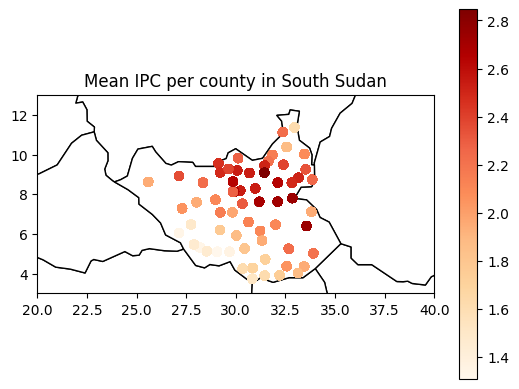

In [6]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [7]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom', 'ruggedness_mean', 'pop', 'cropland_pct', 'sum_fatalities', 'et_anom', 'rain_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
        'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
        'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
        'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
        'count_violence_lag_3', 'ndvi_anom_lag_3', 'ruggedness_mean_lag_3',
        'pop_lag_3', 'cropland_pct_lag_3', 'sum_fatalities_lag_3',
        'et_anom_lag_3', 'rain_anom_lag_3', 'food_price_idx_lag_3', 'ipc_lag_1',
        'ipc_lag_2', 'ipc_lag_3'],
       dtype='object'),
 33)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          10112 non-null  float64
 1   centx                  10112 non-null  float64
 2   centy                  10112 non-null  float64
 3   year                   10112 non-null  float64
 4   month                  10112 non-null  float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              10112 non-null  float64
 8   ndvi_anom              10112 non-null  float64
 9   rain_mean              10112 non-null  float64
 10  rain_anom              10112 non-null  float64
 11  et_mean                10112 non-null  float64
 12  et_anom                10112 non-null  float64
 13  count_violence        

In [9]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [10]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)

#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)
    
#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [11]:
news_df = pd.read_csv(data_dir + "df_news_districted.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df = news_df.drop(columns=['Unnamed: 0'])
news_df = news_df.rename(columns = {'districts': 'district'})
# news_df = news_df.rename(columns={"location_article": "district"})

In [12]:
news_df

,title,date,paragraphs,publisher,hunger,refugees,humanitarian,conflict,district
0,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Bor
1,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Jur River
2,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Aweil
3,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Morobo
4,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Magwi
...,...,...,...,...,...,...,...,...,...
361099,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Fashoda
361100,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Manyo
361101,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Melut
361102,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Renk


In [13]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date", 'district'])[column].sum()
        col = col.fillna(0)
        col = col.rolling(3).sum()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [14]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

# news_features.plot();
news_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9156 entries, (Timestamp('2011-05-01 00:00:00'), 'Abiemnhom') to (Timestamp('2023-04-01 00:00:00'), 'Mayom')
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hunger        9151 non-null   float64
 1   refugees      9151 non-null   float64
 2   conflict      9151 non-null   float64
 3   humanitarian  9151 non-null   float64
dtypes: float64(4)
memory usage: 314.7+ KB


In [15]:
news_features

hunger  refugees  conflict  humanitarian
date       district                                           
2011-05-01 Abiemnhom     NaN       NaN       NaN           NaN
           Akobo         NaN       NaN       NaN           NaN
           Anzara        NaN       NaN       NaN           NaN
           Aweil         NaN       NaN       NaN           NaN
           Awerial       NaN       NaN       NaN           NaN
...                      ...       ...       ...           ...
2023-03-01 Yirol         0.0       0.0       0.0           0.0
2023-04-01 Juba          0.0       0.0       0.0           0.0
           Koch          0.0       0.0       0.0           0.0
           Leer          0.0       0.0       0.0           0.0
           Mayom         0.0       0.0       0.0           0.0

[9156 rows x 4 columns]

In [16]:
# # Get the mean share of articles per ipc for the different topics
# combined = (
#     pd.DataFrame(y['ipc'])
#     .join(news_df.groupby(["date", "district"])["hunger"].mean())
#     .join(news_df.groupby(["date", "district"])["refugees"].mean())
#     .join(news_df.groupby(["date", "district"])["conflict"].mean())
#     .join(news_df.groupby(["date", "district"])["humanitarian"].mean())
# )


# # Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );

NameError: name 'y' is not defined

## Predicting using news features

In [17]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          8192 non-null   float64
 1   centx                  8192 non-null   float64
 2   centy                  8192 non-null   float64
 3   year                   8192 non-null   float64
 4   month                  8192 non-null   float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              8192 non-null   float64
 8   ndvi_anom              8192 non-null   float64
 9   rain_mean              8192 non-null   float64
 10  rain_anom              8192 non-null   float64
 11  et_mean                8192 non-null   float64
 12  et_anom                8192 non-null   float64
 13  count_violence         

In [19]:
df['hunger'] = df['hunger'].fillna(0)
df['refugees'] = df['refugees'].fillna(0)
df['conflict'] = df['conflict'].fillna(0)
df['humanitarian'] = df['humanitarian'].fillna(0)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          8192 non-null   float64
 1   centx                  8192 non-null   float64
 2   centy                  8192 non-null   float64
 3   year                   8192 non-null   float64
 4   month                  8192 non-null   float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              8192 non-null   float64
 8   ndvi_anom              8192 non-null   float64
 9   rain_mean              8192 non-null   float64
 10  rain_anom              8192 non-null   float64
 11  et_mean                8192 non-null   float64
 12  et_anom                8192 non-null   float64
 13  count_violence         

In [21]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.metrics import accuracy_score, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model


# # df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


# X = df.iloc[:, -14:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
#     X_test = X_test[X_train.columns]
    
#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)
    
#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data

#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [22]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [23]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
# acc_values = list() # Initinalize empty lists to score accuracy scores

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
#     y_binary = y > 2 # Convert y to binary variable
#     y_binary[y.isna()] = pd.NA # Conserve NaN values
#     y_binary = y_binary.astype("float32") # Convert y to float

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)
    
#     cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
#     model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test[cols]) # Run model on test data

#     # Convert prediction and validation to boolean
#     y_pred = y_pred.round().astype(bool)
#     y_val = y_val.round().astype(bool)

#     # Drop all rows from prediction and validation where validation is null
#     y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
#     y_val.dropna(inplace=True)

#     acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
# print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc
# df.info()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_code          8192 non-null   float64
 1   centx                  8192 non-null   float64
 2   centy                  8192 non-null   float64
 3   year                   8192 non-null   float64
 4   month                  8192 non-null   float64
 5   ipc                    2496 non-null   float64
 6   ha                     1792 non-null   float64
 7   ndvi_mean              8192 non-null   float64
 8   ndvi_anom              8192 non-null   float64
 9   rain_mean              8192 non-null   float64
 10  rain_anom              8192 non-null   float64
 11  et_mean                8192 non-null   float64
 12  et_anom                8192 non-null   float64
 13  count_violence         

In [33]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge


# df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


X = df.iloc[:, -16:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    model = linear_model.Ridge(alpha=3)

    results = model.fit(X_train, y_train, ) # Get model results on training data

    # print(results.summary()) # Print model summary

    y_pred = results.predict(X_test).T[0] # Run model on test data
    # y_pred = y_pred.T[0]

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    # cur_r2 = results.rsquared
    cur_r2 = r2_score(y_pred=results.predict(X_train),
                      y_true=y_train['ipc'])
    r2_values.append(cur_r2)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [32]:
y = y[X['ipc_lag_3'].notnull()]
X = X[X['ipc_lag_3'].notnull()]

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)



# Normalize your data (optional, but recommended)
scaler = StandardScaler()
X_train_model = scaler.fit_transform(X_train.values)
X_test_model = scaler.transform(X_test.values)

# Convert data to PyTorch tensors
X_train_model = torch.FloatTensor(X_train_model)
X_test_model = torch.FloatTensor(X_test_model)
y_train_model = torch.LongTensor(y_train.values)
y_test_model = torch.LongTensor(y_test.values)

# Subtract 1 from the target labels to make them range from 0 to 4
y_train_model = torch.LongTensor([label - 1 for label in y_train_model]).unsqueeze(dim=1)
y_test_model = torch.LongTensor([label - 1 for label in y_test_model]).unsqueeze(dim=1)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_model, y_train_model)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_model, y_test_model)
test_loader = DataLoader(test_dataset, batch_size=64)


In [39]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split



class HungerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HungerModel, self).__init__()
        self.linear_layer_1 = nn.Linear(input_size, 64)
        self.linear_layer_2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.linear_layer_1(x))
        x = self.linear_layer_2(x)
        return x

# Define class weights based on ordinal distance
class_weights = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

input_size = X_train.shape[1]
num_classes = 5

model = HungerModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 1500
best_loss = 10000



for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss for each epoch
    
    if loss < best_loss:
        best_loss = loss
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

model = HungerModel(input_size, num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [1/1500] Loss: 1.5806
Epoch [3/1500] Loss: 1.5277
Epoch [4/1500] Loss: 1.4676
Epoch [5/1500] Loss: 1.4585
Epoch [6/1500] Loss: 1.3623
Epoch [7/1500] Loss: 1.3029
Epoch [9/1500] Loss: 1.2908
Epoch [10/1500] Loss: 1.2534
Epoch [14/1500] Loss: 1.1345
Epoch [16/1500] Loss: 1.0688
Epoch [22/1500] Loss: 1.0569
Epoch [24/1500] Loss: 0.9558
Epoch [28/1500] Loss: 0.9354
Epoch [33/1500] Loss: 0.9189
Epoch [36/1500] Loss: 0.8885
Epoch [38/1500] Loss: 0.8604
Epoch [40/1500] Loss: 0.8154
Epoch [41/1500] Loss: 0.8126
Epoch [57/1500] Loss: 0.6519
Epoch [87/1500] Loss: 0.6311
Epoch [101/1500] Loss: 0.5905
Epoch [165/1500] Loss: 0.5680
Epoch [174/1500] Loss: 0.5569
Epoch [186/1500] Loss: 0.4802
Epoch [271/1500] Loss: 0.4532
Epoch [446/1500] Loss: 0.4352
Epoch [587/1500] Loss: 0.4016
Epoch [863/1500] Loss: 0.3768
Epoch [905/1500] Loss: 0.3728
Epoch [1076/1500] Loss: 0.3603
Epoch [1145/1500] Loss: 0.3096


HungerModel(
  (linear_layer_1): Linear(in_features=17, out_features=64, bias=True)
  (linear_layer_2): Linear(in_features=64, out_features=5, bias=True)
)

In [40]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, _ = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        # Print predicted classes (1 to 5)
        # print(predicted_classes.numpy())


Confusion Matrix:
[[462 168   6   0   0]
 [ 49 653 116   2   0]
 [  4  95 545  44   0]
 [  0   4  67  88   0]
 [  0   0   0   0   1]]
Accuracy: 0.7591145833333334
F1 Score: 0.7595129773880201


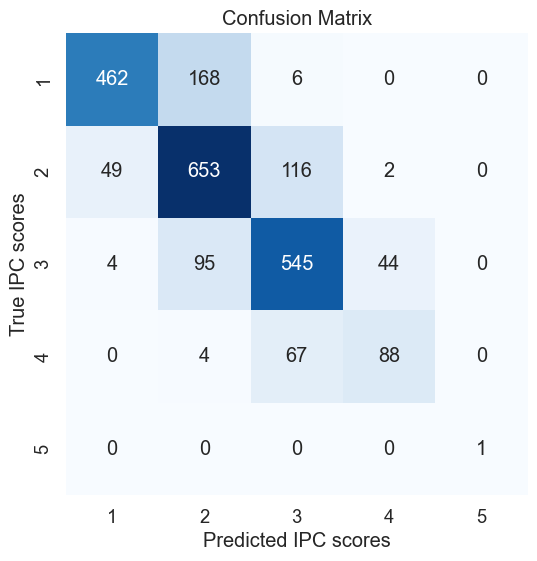

Accuracy: 0.7591145833333334
F1 Score: 0.7595129773880201
Mean Squared Error (MSE): 0.26171875
Mean Absolute Error (MAE): 0.2478298611111111


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probabilities = []  # Added for MSE and MAE

combined_dataset = ConcatDataset([
    TensorDataset(X_train_model, y_train_model),
    TensorDataset(X_test_model, y_test_model)
])

combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for batch in combined_loader:
        inputs, labels = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted_classes.numpy())
        predicted_probabilities.extend(probabilities.numpy())  # Added for MSE and MAE

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# Calculate MSE and MAE
# Calculate MSE and MAE

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=[str(i+1) for i in range(num_classes)],
            yticklabels=[str(i+1) for i in range(num_classes)])
plt.xlabel('Predicted IPC scores')
plt.ylabel('True IPC scores')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print("F1 Score:", f1)
# ... (remaining code for MSE and MAE)

# Convert true_labels to one-hot encoded format
num_classes = 5  # Assuming you have 5 classes
true_labels_onehot = np.zeros((len(true_labels), num_classes))
true_labels_onehot[np.arange(len(true_labels)), true_labels] = 1

mse = np.mean(np.square(np.array(predicted_labels) - [i[0] for i in true_labels]))
mae = np.mean(np.abs(np.array(predicted_labels) - [i[0] for i in true_labels]))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


<Axes: xlabel='ipc', ylabel='Density'>

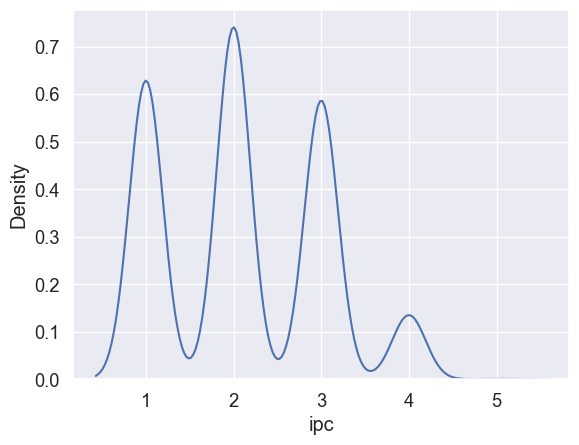

In [42]:
from seaborn import kdeplot, histplot

kdeplot(y[y['ipc'].notnull()]['ipc'])

5.0


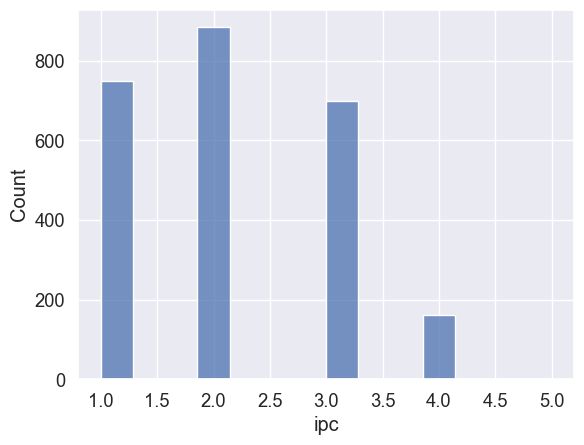

In [43]:
histplot(y['ipc'])
print(y['ipc'].max())

In [44]:
predict_prob_list = np.ndarray(len(predicted_probabilities))
for i in range(len(predicted_probabilities)):
    if i % 10 == 0:
        print()
    predict_prob_list[i] = predicted_probabilities[i].max()
    print(f"{100*predicted_probabilities[i].max():.2f}%", end=" ")


93.44% 71.77% 97.73% 72.99% 49.22% 90.15% 68.34% 92.59% 66.32% 72.47% 
56.02% 92.64% 59.91% 87.80% 73.38% 69.18% 86.96% 79.44% 67.66% 68.98% 
57.13% 66.38% 66.38% 68.62% 84.55% 60.48% 86.78% 89.67% 95.72% 91.59% 
51.52% 89.75% 97.87% 68.30% 67.10% 65.32% 52.79% 84.76% 96.45% 67.47% 
96.50% 79.42% 65.98% 71.09% 95.74% 76.34% 83.89% 54.10% 80.41% 80.30% 
57.53% 80.44% 75.54% 61.84% 89.83% 70.15% 82.19% 66.29% 66.38% 77.86% 
76.55% 66.82% 89.28% 76.66% 83.55% 92.73% 77.94% 71.66% 86.32% 85.33% 
46.90% 81.78% 99.32% 92.01% 51.93% 57.57% 84.12% 86.32% 80.25% 60.65% 
62.05% 46.78% 74.41% 85.08% 43.68% 86.82% 63.58% 77.34% 56.93% 62.07% 
84.49% 89.74% 58.63% 83.70% 90.62% 75.41% 93.53% 83.34% 78.07% 46.07% 
91.55% 79.00% 44.94% 65.73% 96.11% 50.03% 66.56% 78.93% 88.34% 96.45% 
79.83% 51.73% 92.37% 96.59% 69.42% 86.30% 70.42% 74.33% 94.03% 64.14% 
58.16% 53.69% 88.30% 98.93% 74.50% 55.90% 66.98% 82.42% 61.06% 51.46% 
91.53% 81.19% 75.44% 81.56% 67.78% 91.23% 68.11% 83.41% 95.82% 68.67% 
63.05

<Axes: ylabel='Count'>

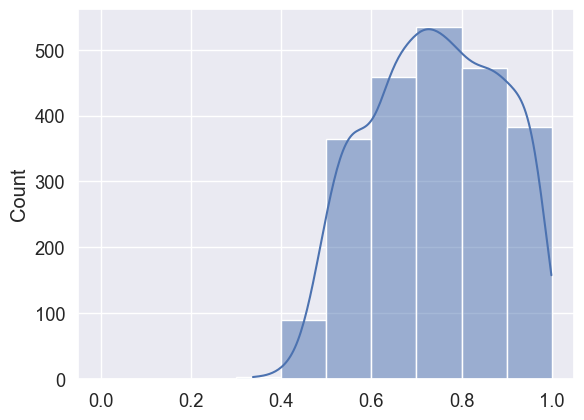

In [45]:
histplot(predict_prob_list, bins=[i/10 for i in range(11)], kde=True)

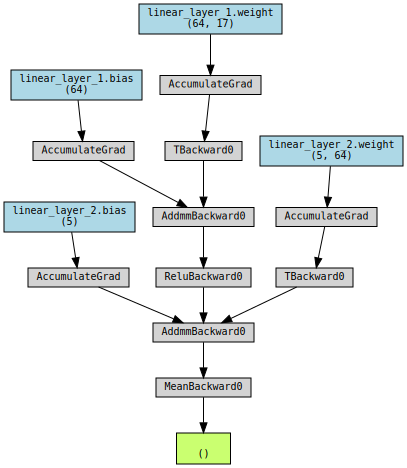

In [46]:
from torchviz import make_dot

make_dot(model(inputs).mean(), params=dict(model.named_parameters()))

In [47]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, inputs)
writer.close()

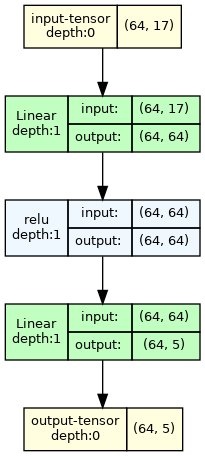

In [50]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph = draw_graph(model, input_size=(64, 17), device='meta')
model_graph.visual_graph

In [48]:
inputs.shape

torch.Size([64, 17])